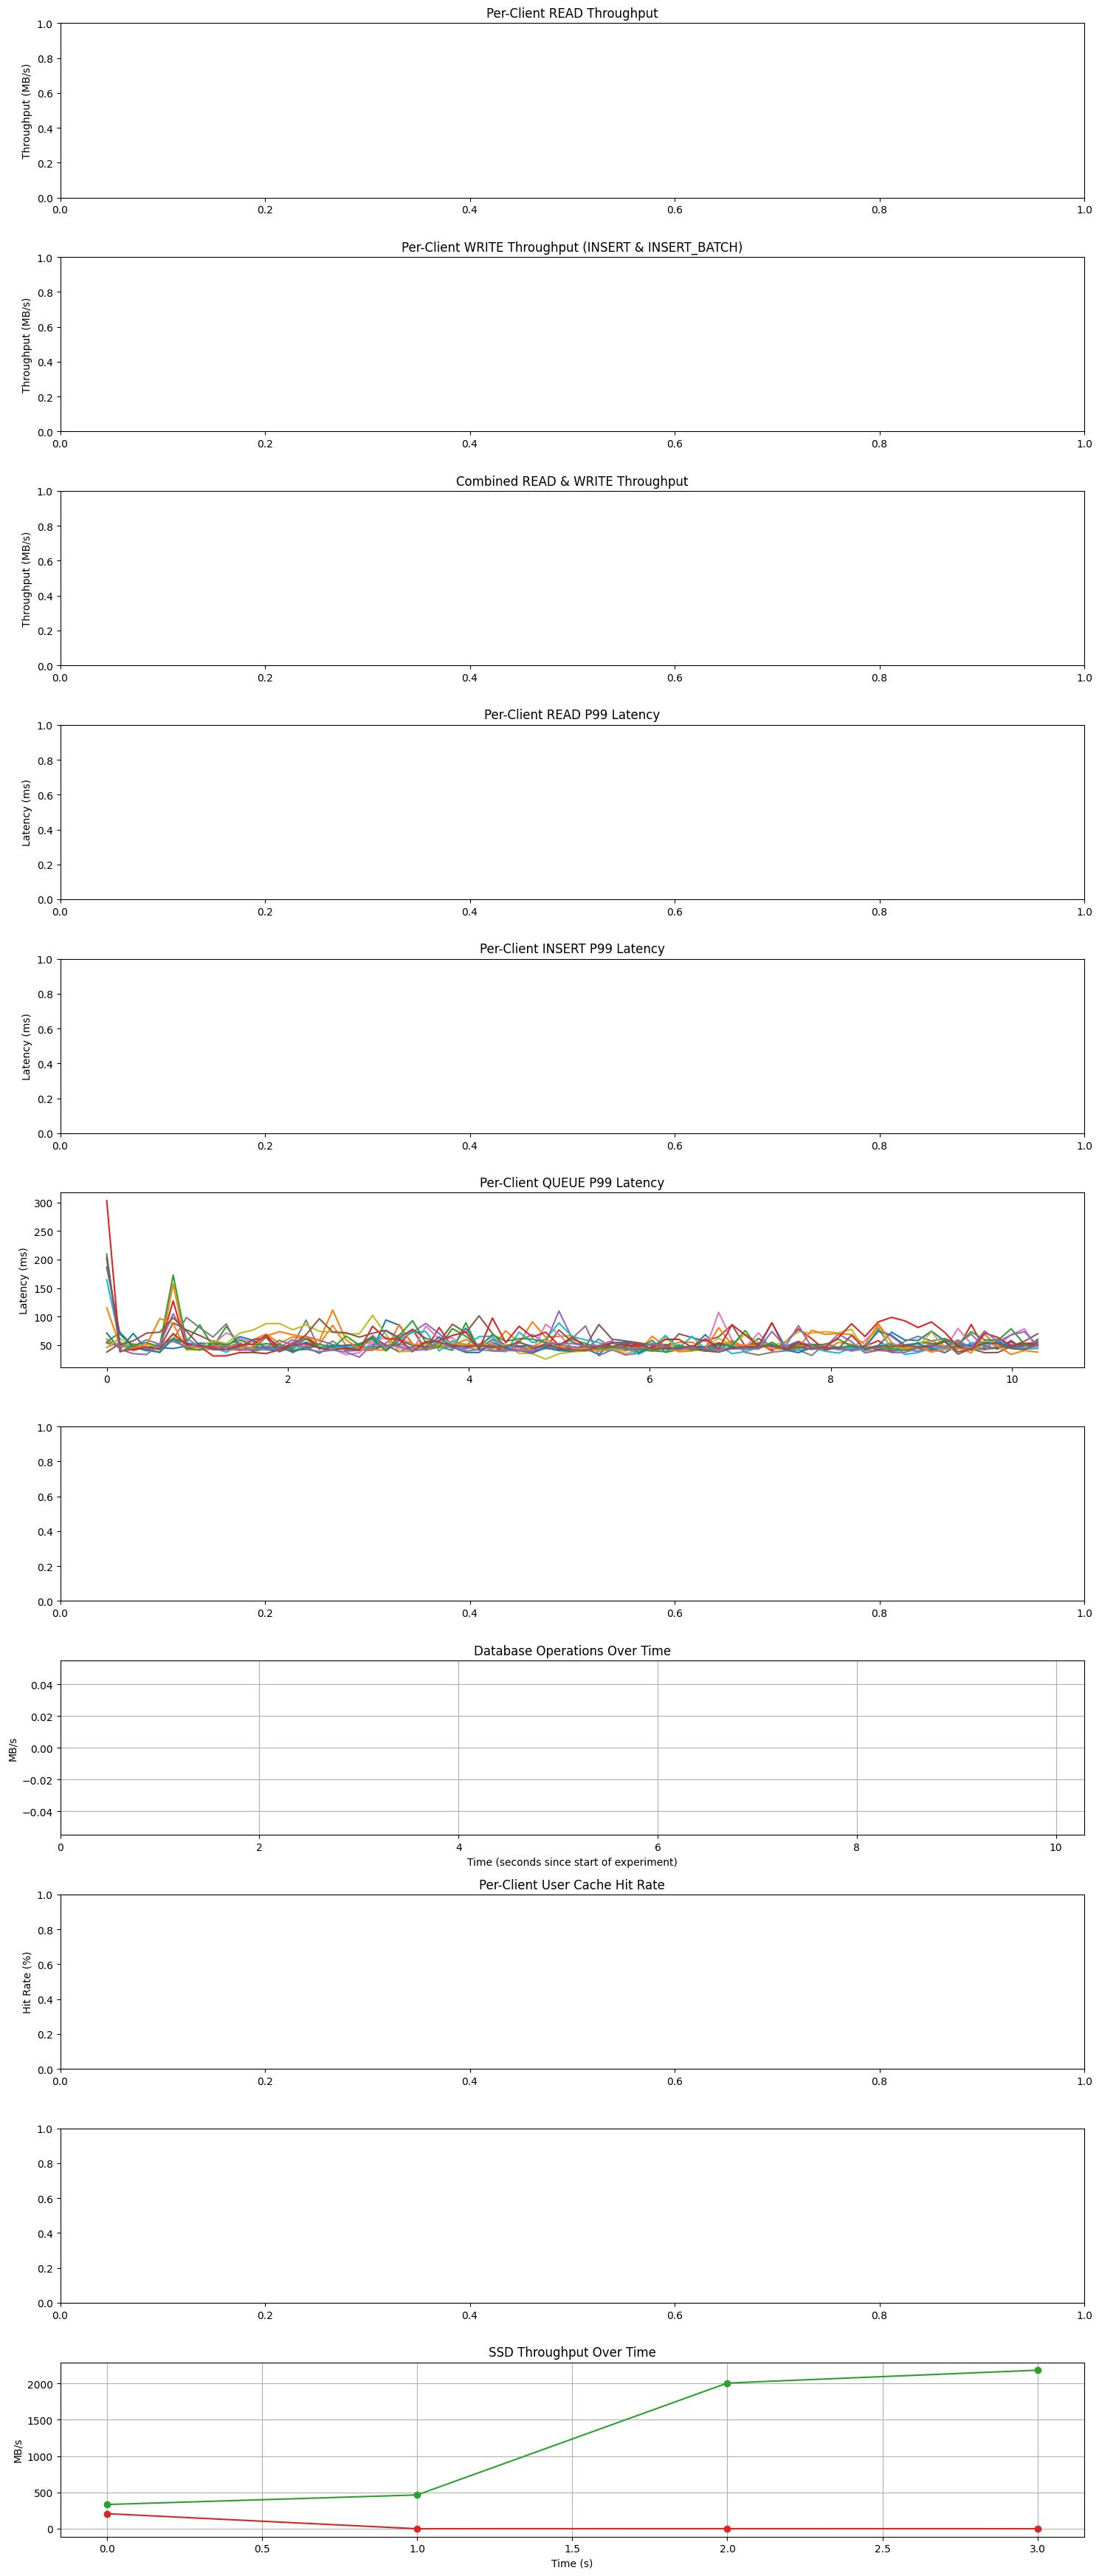

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import json
from datetime import datetime
from collections import defaultdict

# Configuration: Operation sizes (in KB)
READ_SIZE_KB = 4   # Size of a single READ operation
INSERT_SIZE_KB = 1 # Size of a single INSERT operation
INSERT_BATCH_SIZE_KB = 100 # Size of a single INSERT_BATCH operation

READ_SIZE_MB = READ_SIZE_KB / 1024
INSERT_SIZE_MB = INSERT_SIZE_KB / 1024
INSERT_BATCH_SIZE_MB = INSERT_BATCH_SIZE_KB / 1024

df = pd.read_csv('logs/client_stats.log')
df['relative_time_ms'] = df['timestamp'] - df['timestamp'].min()
df['relative_time_s'] = df['relative_time_ms'] / 1000.0

df = df.sort_values(by=['client_id', 'op_type', 'timestamp'])
df['time_diff_s'] = df.groupby(['client_id', 'op_type'])['relative_time_s'].diff()

df['throughput'] = df['count'] / df['time_diff_s']
df['throughput_mb_s'] = 0.0

df.loc[df['op_type'] == 'SCAN', 'throughput_mb_s'] = df['throughput'] * READ_SIZE_MB * 100
df.loc[df['op_type'] == 'INSERT', 'throughput_mb_s'] = df['throughput'] * INSERT_SIZE_MB
df.loc[df['op_type'] == 'INSERT_BATCH', 'throughput_mb_s'] = df['throughput'] * INSERT_BATCH_SIZE_MB

df_throughput = df.dropna(subset=['throughput_mb_s'])

df_read = df_throughput[df_throughput['op_type'] == 'READ']
df_insert = df_throughput[df_throughput['op_type'] == 'INSERT']
df_insert_batch = df_throughput[df_throughput['op_type'] == 'INSERT_BATCH']
df_queue_latency = df[df['op_type'] == 'QUEUE']
df_read_latency = df[df['op_type'] == 'READ']
df_insert_latency = df[df['op_type'] == 'INSERT']

df_read = df_read.copy()
df_read['user_cache_total'] = df_read['user_cache_hits'] + df_read['user_cache_misses']
df_read['user_cache_hit_rate'] = np.where(
    df_read['user_cache_total'] > 0,
    (df_read['user_cache_hits'] / df_read['user_cache_total']) * 100.0,
    np.nan
)

df_cache_usage = df_read[['relative_time_s', 'client_id', 'user_cache_usage']].dropna()
df_cache_usage_pivot = df_cache_usage.pivot_table(
    index='relative_time_s',
    columns='client_id',
    values='user_cache_usage',
    aggfunc='mean',
    fill_value=10000000
)

# Unified color palette (shades of red)
colors = ["#ffc1c1", "#fc9598", "#ff696e", "#f02225", "#cf1d20", "#ab1619", "#851114", "#610c0e"]

def plot_memtable_shares(ax, file_path):
    client_data = defaultdict(lambda: {'global': [], 'steady': []})
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("wbm"):
                parts = line.strip().split(',')
                if len(parts) == 7 and parts[3] == 'res':
                    try:
                        _, timestamp, client_id_str, operation, operation_size, current_value_str, steady_or_global = parts
                        timestamp = int(timestamp) / 1000
                        client_id = int(client_id_str)
                        current_value = int(current_value_str) / (1024 * 1024)
                        if steady_or_global.strip() in ['steady', 'global']:
                            client_data[client_id][steady_or_global.strip()].append((timestamp, current_value))
                    except ValueError:
                        continue
                elif len(parts) == 8 and parts[3] == 'free':
                    try:
                        _, timestamp, client_id_str, operation, operation_size, current_value_str, global_str, steady_str = parts
                        timestamp = int(timestamp) / 1000
                        client_id = int(client_id_str)
                        global_value = int(global_str.split(':')[1]) / (1024 * 1024)
                        steady_value = int(steady_str.split(':')[1]) / (1024 * 1024)
                        client_data[client_id]['global'].append((timestamp, global_value))
                        client_data[client_id]['steady'].append((timestamp, steady_value))
                    except (ValueError, IndexError):
                        continue
    try:
        start_time = min(
            min((timestamps[0][0] for timestamps in client.values() if len(timestamps) > 0), default=float('inf'))
            for client in client_data.values()
        )
    except:
        return

    for client_id in client_data:
        for key in ['global', 'steady']:
            values = client_data[client_id][key]
            adjusted_values = [(t - start_time, v) for t, v in values]
            client_data[client_id][key] = np.array(adjusted_values)

    all_timestamps = sorted(set(
        t
        for cvals in client_data.values()
        for key in ['global', 'steady']
        for t, _ in cvals[key]
    ))

    latest_values = {cid: {'global': 0, 'steady': 0} for cid in client_data}
    total_usage_values = []
    sum_steady_values = []
    sum_global_values = []

    for ts in all_timestamps:
        total_global = 0
        total_steady = 0
        total_usage = 0
        for cid in client_data:
            for key in ['global', 'steady']:
                vals = client_data[cid][key]
                if len(vals) == 0:
                    continue
                mask = vals[:, 0] <= ts
                if np.any(mask):
                    latest_values[cid][key] = vals[mask, 1][-1]
            total_client_usage = latest_values[cid]['global'] + latest_values[cid]['steady']
            total_usage += total_client_usage
            total_global += latest_values[cid]['global']
            total_steady += latest_values[cid]['steady']
        total_usage_values.append((ts, total_usage))
        sum_steady_values.append((ts, total_steady))
        sum_global_values.append((ts, total_global))

    total_usage_values = np.array(total_usage_values)
    sum_steady_values = np.array(sum_steady_values)
    sum_global_values = np.array(sum_global_values)

    client_total_usage = {}
    for cid in client_data:
        timestamps = []
        usage_values = []
        lv = {'global': 0, 'steady': 0}
        for ts in all_timestamps:
            for key in ['global', 'steady']:
                vals = client_data[cid][key]
                if len(vals) == 0:
                    continue
                mask = vals[:, 0] <= ts
                if np.any(mask):
                    lv[key] = vals[mask, 1][-1]
            total_client_usage = lv['global'] + lv['steady']
            timestamps.append(ts)
            usage_values.append(total_client_usage)
        client_total_usage[cid] = np.array([timestamps, usage_values])

    for cid, data in client_total_usage.items():
        ax.plot(data[0], data[1], label=f"Client {cid} Total Usage")

    ax.plot(total_usage_values[:, 0], total_usage_values[:, 1], label="All Clients Total Usage", color="black", linewidth=2)
    ax.plot(sum_steady_values[:, 0], sum_steady_values[:, 1], label="Total Steady Usage", color="green", linestyle="--", linewidth=2)
    ax.plot(sum_global_values[:, 0], sum_global_values[:, 1], label="Total Global Usage", color="blue", linestyle=":", linewidth=2)

    ax.set_xlabel("Time Since Start (s)")
    ax.set_ylabel("Usage (MB)")
    ax.set_title("Memtable Shares Over Time")
    # ax.legend()
    ax.grid(True)

def plot_database_operations(ax, experiment_start_time, xlim=None):
    log_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'

    # Regex patterns
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[(.*?)\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')
    memtable_stop_pattern = re.compile(r'Stopping writes because we have \d+ immutable memtables.*')
    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')

    def timestamp_to_seconds(timestamp_str):
        dt = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (dt - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        dt = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return int((dt - epoch).total_seconds() * 1_000_000)

    # Data structures to hold events
    l0_stalls, memtable_stalls, pending_compaction_stalls = [], [], []
    flush_data = {}
    compaction_data = {}
    memtable_stops = []

    # Parse the LOG file
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 stalls
            if l0_stall_pattern.search(line):
                ts_str = line.split(' ')[0]
                timestamp_micros = timestamp_to_micros(ts_str)
                rate = int(l0_stall_pattern.search(line).group(1)) / (1024*1024)
                l0_stalls.append((timestamp_micros, rate))

            # Memtable stalls
            if memtable_stall_pattern.search(line):
                ts_str = line.split(' ')[0]
                timestamp_micros = timestamp_to_micros(ts_str)
                rate = int(memtable_stall_pattern.search(line).group(1)) / (1024*1024)
                memtable_stalls.append((timestamp_micros, rate))

            # Pending compaction stalls
            if pending_compaction_stall_pattern.search(line):
                ts_str = line.split(' ')[0]
                timestamp_micros = timestamp_to_micros(ts_str)
                rate = int(pending_compaction_stall_pattern.search(line).group(1)) / (1024*1024)
                pending_compaction_stalls.append((timestamp_micros, rate))

            # Memtable stops
            if memtable_stop_pattern.search(line):
                ts_str = line.split(' ')[0]
                timestamp_micros = timestamp_to_micros(ts_str)
                memtable_stops.append((timestamp_micros, "default"))

            # Flush events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, cf_name, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds)/1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                if "flush" not in flush_data:
                    flush_data["flush"] = []
                flush_data["flush"].append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))

            # Compaction events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] == 'compaction_finished':
                        end_time_seconds = event_data['time_micros'] / 1e6
                        start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                        write_rate = event_data['write_rate']
                        output_level = event_data['output_level']
                        if "compaction" not in compaction_data:
                            compaction_data["compaction"] = []
                        compaction_data["compaction"].append((start_time_seconds, end_time_seconds, write_rate, output_level))
                except:
                    pass

    # Adjust timestamps by experiment_start_time
    l0_timestamps = [(ts/1e6) - experiment_start_time for ts,_ in l0_stalls]
    l0_rates = [r for _,r in l0_stalls]

    memtable_timestamps = [(ts/1e6)-experiment_start_time for ts,_ in memtable_stalls]
    memtable_rates = [r for _,r in memtable_stalls]

    pending_compaction_timestamps = [(ts/1e6)-experiment_start_time for ts,_ in pending_compaction_stalls]
    pending_compaction_rates = [r for _,r in pending_compaction_stalls]

    # Plot stalls
    ax.scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    ax.scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
    ax.scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    # Set flush and compaction colors
    flush_color = 'blue'  # Flushes are always blue
    # Red palette for compactions (shades of red based on output level)
    compaction_colors = ["#ffc1c1", "#fc9598", "#ff696e", "#f02225", "#cf1d20", "#ab1619", "#851114", "#610c0e"]

    def get_compaction_color(level):
        # Pick a color based on the output level
        idx = min(level-1, len(compaction_colors)-1)
        return compaction_colors[idx]

    # Only two labels: "Flush" and "Compaction"
    flush_label_added = False
    compaction_label_added = False

    # Plot Flushes
    if "flush" in flush_data:
        for i, (start_time, rate, duration) in enumerate(flush_data["flush"]):
            lbl = "Flush" if not flush_label_added else ""
            flush_label_added = True
            ax.hlines(rate,
                      start_time - experiment_start_time,
                      (start_time + duration) - experiment_start_time,
                      colors=flush_color, linewidth=4, linestyles='solid', label=lbl)

    # Plot Compactions
    if "compaction" in compaction_data:
        for i, (start_time, end_time, write_rate, output_level) in enumerate(compaction_data["compaction"]):
            c_color = get_compaction_color(output_level)
            lbl = "Compaction" if not compaction_label_added else ""
            compaction_label_added = True
            ax.hlines(write_rate,
                      start_time - experiment_start_time,
                      end_time - experiment_start_time,
                      colors=c_color, linewidth=2, label=lbl)

    # Plot memtable stops
    for i, (ts, cf_name) in enumerate(memtable_stops):
        stop_ts = (ts/1e6)-experiment_start_time
        ax.axvline(x=stop_ts, color='brown', linestyle='--', linewidth=0.5, alpha=0.5,
                   label='Memtable Stops' if i == 0 else "")

    ax.set_title('Database Operations Over Time')
    ax.set_xlabel('Time (seconds since start of experiment)')
    ax.set_ylabel('MB/s')
    if xlim is not None:
        ax.set_xlim(xlim)
    # ax.legend()
    ax.grid(True)

# Adjusting subplot order
experiment_start_time = df['timestamp'].min() / 1000.0
xlim = (0, df['relative_time_s'].max())

fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(15, 35), sharex=False)
fig.subplots_adjust(hspace=0.4)

# 1. Per-Client READ Throughput
ax1 = axes[0]
for client_id, grp in df_read.groupby('client_id'):
    ax1.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id}')
ax1.set_title('Per-Client READ Throughput')
ax1.set_ylabel('Throughput (MB/s)')
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 2. Per-Client WRITE Throughput (INSERT & INSERT_BATCH)
ax2 = axes[1]
for client_id, grp in df_insert.groupby('client_id'):
    ax2.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id} INSERT')
for client_id, grp in df_insert_batch.groupby('client_id'):
    ax2.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id} INSERT_BATCH')
ax2.set_title('Per-Client WRITE Throughput (INSERT & INSERT_BATCH)')
ax2.set_ylabel('Throughput (MB/s)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 3. Combined READ & WRITE Throughput
ax3 = axes[2]
combined_ops = df_throughput[df_throughput['op_type'].isin(['READ', 'INSERT', 'INSERT_BATCH'])]
for (client_id, op_type), grp in combined_ops.groupby(['client_id', 'op_type']):
    ax3.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id}, {op_type}')
ax3.set_title('Combined READ & WRITE Throughput')
ax3.set_ylabel('Throughput (MB/s)')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 4. P99 READ Latency
ax4 = axes[3]
for client_id, grp in df_read_latency.groupby('client_id'):
    ax4.plot(grp['relative_time_s'], grp['99p'], label=f'Client {client_id}')
ax4.set_title('Per-Client READ P99 Latency')
ax4.set_ylabel('Latency (ms)')
# ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 5. P99 INSERT Latency
ax5 = axes[4]
for client_id, grp in df_insert_latency.groupby('client_id'):
    ax5.plot(grp['relative_time_s'], grp['99p'], label=f'Client {client_id}')
ax5.set_title('Per-Client INSERT P99 Latency')
ax5.set_ylabel('Latency (ms)')
# ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 6. P99 QUEUE Latency
ax6 = axes[5]
for client_id, grp in df_queue_latency.groupby('client_id'):
    ax6.plot(grp['relative_time_s'], grp['99p'], label=f'Client {client_id}')
ax6.set_title('Per-Client QUEUE P99 Latency')
ax6.set_ylabel('Latency (ms)')
# ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 7. Memtable Shares Over Time
ax7 = axes[6]
plot_memtable_shares(ax7, "logs/memtable_stats.txt")

# 8. Database Operations Over Time
ax8 = axes[7]
plot_database_operations(ax8, experiment_start_time=experiment_start_time, xlim=xlim)

try:
    # 9. User Cache Hit Rate (per-client line)
    ax9 = axes[8]
    for client_id, grp in df_read.groupby('client_id'):
        valid_grp = grp.dropna(subset=['user_cache_hit_rate'])
        if not valid_grp.empty:
            ax9.plot(valid_grp['relative_time_s'], valid_grp['user_cache_hit_rate'], label=f'Client {client_id}')
    ax9.set_title('Per-Client User Cache Hit Rate')
    ax9.set_ylabel('Hit Rate (%)')
    # ax9.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # 10. User Cache Usage (Stacked)
    ax10 = axes[9]
    x = df_cache_usage_pivot.index
    y = df_cache_usage_pivot.values.T
    ax10.stackplot(x, y, labels=df_cache_usage_pivot.columns)
    ax10.set_title('Per-Client User Cache Usage (Stacked)')
    ax10.set_ylabel('Cache Usage')
    # ax10.legend(loc='center left', bbox_to_anchor=(1, 0.5))
except:
    pass

# 11. SSD Throughput Over Time
df_iostat = pd.read_csv("iostat_results.csv")
time_seconds = np.arange(len(df_iostat))
start_time_shift = 0
time_seconds = [t + start_time_shift for t in time_seconds]

ax11 = axes[10]
ax11.plot(time_seconds, df_iostat["rMB/s"], label='Read MB/s', marker='o', color='tab:green')
ax11.plot(time_seconds, df_iostat["wMB/s"], label='Write MB/s', marker='o', color='tab:red')
ax11.set_title('SSD Throughput Over Time')
ax11.set_xlabel('Time (s)')
ax11.set_ylabel('MB/s')
# ax11.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax11.grid(True)

plt.tight_layout()
plt.show()